In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

%matplotlib inline

# plt.style.use('seaborn-v0_8-colorblind')

plt.style.use('ggplot')


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def plotMovingAverage(series, pos_init, pos_final, assintotas = False, sub_assintotas = False, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=pos_init).mean()

    plt.figure(figsize=(21,7))
    # plt.title("Moving average\n window size = {}".format(window))
    plt.title("Média Móvel - Latência")
    plt.plot(rolling_mean[pos_init:pos_final], "y", label="Tendencia Média Móvel", zorder = 2)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[pos_init:pos_final], rolling_mean[pos_init:pos_final])
        deviation = np.std(series[pos_init:pos_final] - rolling_mean[pos_init:pos_final])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond[pos_init:pos_final], "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond[pos_init:pos_final], "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=5)

    if assintotas:
        assintotas_list = [1800, 5400, 9000, 12600]
        for x in assintotas_list:
            plt.axvline(x=x, color='gray', linestyle='--')

    if sub_assintotas:
        sub_list = [3000, 4200, 6600, 7800, 10200, 11400]
        for x in sub_list:
            plt.axvline(x=x, color='gray', linestyle='--')

    plt.plot(series[pos_init:pos_final], label="Latência Média", zorder = 1)
    plt.legend(loc="upper left")
    # plt.grid(True)

In [4]:
data_path = "../datasets/unloaded-res.csv"
dedicated_path = "../datasets/dedicated-res.csv"
data_path_remake = "../datasets/02-unloaded-res.csv"

df_before = pd.read_csv(data_path)
dedicated = pd.read_csv(dedicated_path)
df = pd.read_csv(data_path_remake)

df.time = df.time.astype(int)
df.time = df.time - 1

dedicated.time = dedicated.time.astype(int)
dedicated.time = dedicated.time -1

df_before.time = df_before.time.astype(int)
df_before.time = df_before.time - 1

In [5]:
df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1,1000,1001,168,216,235,360,989
1,2,1001,1000,161,207,226,522,1475
2,3,1001,1001,151,193,207,308,567
3,4,1000,1000,164,205,223,505,750
4,5,1000,1000,149,191,208,336,4026


In [6]:
dedicated.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1,1001,1000,161,227,254,412,647
1,2,1000,1001,156,208,228,310,463
2,3,1001,1001,144,210,238,407,570
3,4,1000,1000,163,230,256,414,1072
4,5,1001,1001,150,219,248,430,670


In [7]:
df_before.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1,500,499,192,293,423,3846,6852
1,2,500,501,182,257,312,666,2641
2,3,500,500,168,253,313,799,1718
3,4,500,500,172,226,277,513,1896
4,5,500,499,167,238,295,406,1214


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14399 entries, 0 to 14398
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   time            14399 non-null  int64
 1   sent            14399 non-null  int64
 2   received        14399 non-null  int64
 3   latency_min     14399 non-null  int64
 4   latency_median  14399 non-null  int64
 5   latency_75th    14399 non-null  int64
 6   latency_95th    14399 non-null  int64
 7   latency_99th    14399 non-null  int64
dtypes: int64(8)
memory usage: 900.1 KB


In [9]:
dedicated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14399 entries, 0 to 14398
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   time            14399 non-null  int64
 1   sent            14399 non-null  int64
 2   received        14399 non-null  int64
 3   latency_min     14399 non-null  int64
 4   latency_median  14399 non-null  int64
 5   latency_75th    14399 non-null  int64
 6   latency_95th    14399 non-null  int64
 7   latency_99th    14399 non-null  int64
dtypes: int64(8)
memory usage: 900.1 KB


In [10]:
df.describe()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
count,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000
mean,7200.000000,3257.474686,3257.447184,126.542121,300.916175,696.452115,5984.096465,12274.195777
std,4156.777598,1929.599307,1930.234606,12.631517,204.742038,1331.910655,13660.135183,21284.586903
min,1.000000,880.000000,880.000000,90.000000,162.000000,173.000000,206.000000,268.000000
25%,3600.500000,1917.500000,1918.000000,117.000000,185.000000,202.000000,369.500000,835.500000
50%,7200.000000,3754.000000,3545.000000,124.000000,222.000000,327.000000,949.000000,2809.000000
75%,10799.500000,4745.500000,4708.000000,137.000000,309.000000,765.500000,5007.000000,14021.500000
max,14399.000000,6806.000000,7109.000000,168.000000,3859.000000,88039.000000,189364.000000,217626.000000


In [11]:
dedicated.describe()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
count,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000,14399.000000
mean,7200.000000,4510.991597,4510.993055,116.674630,170.855962,243.295020,739.534343,1667.302104
std,4156.777598,2299.857273,2299.856066,9.856762,41.486895,176.136492,865.291794,2021.255205
min,1.000000,903.000000,903.000000,92.000000,132.000000,142.000000,164.000000,199.000000
25%,3600.500000,2786.500000,2787.000000,109.000000,149.000000,166.000000,289.000000,578.000000
50%,7200.000000,4960.000000,4960.000000,116.000000,161.000000,184.000000,451.000000,900.000000
75%,10799.500000,6530.500000,6524.000000,124.000000,173.000000,227.000000,746.000000,1707.500000
max,14399.000000,8036.000000,8056.000000,164.000000,628.000000,1816.000000,15048.000000,22537.000000


In [12]:
df.columns

Index(['time', 'sent', 'received', 'latency_min', 'latency_median',
       'latency_75th', 'latency_95th', 'latency_99th'],
      dtype='object')

In [13]:
dedicated.columns

Index(['time', 'sent', 'received', 'latency_min', 'latency_median',
       'latency_75th', 'latency_95th', 'latency_99th'],
      dtype='object')

In [14]:
latencia = df[['time', 'latency_median']]
dedicado = dedicated[['time', 'latency_median']]

latencia = latencia.set_index('time')
dedicado = dedicado.set_index('time')

latencia.head()

,latency_median
time,
1,216
2,207
3,193
4,205
5,191


In [15]:
dedicado.head()

,latency_median
time,
1,227
2,208
3,210
4,230
5,219


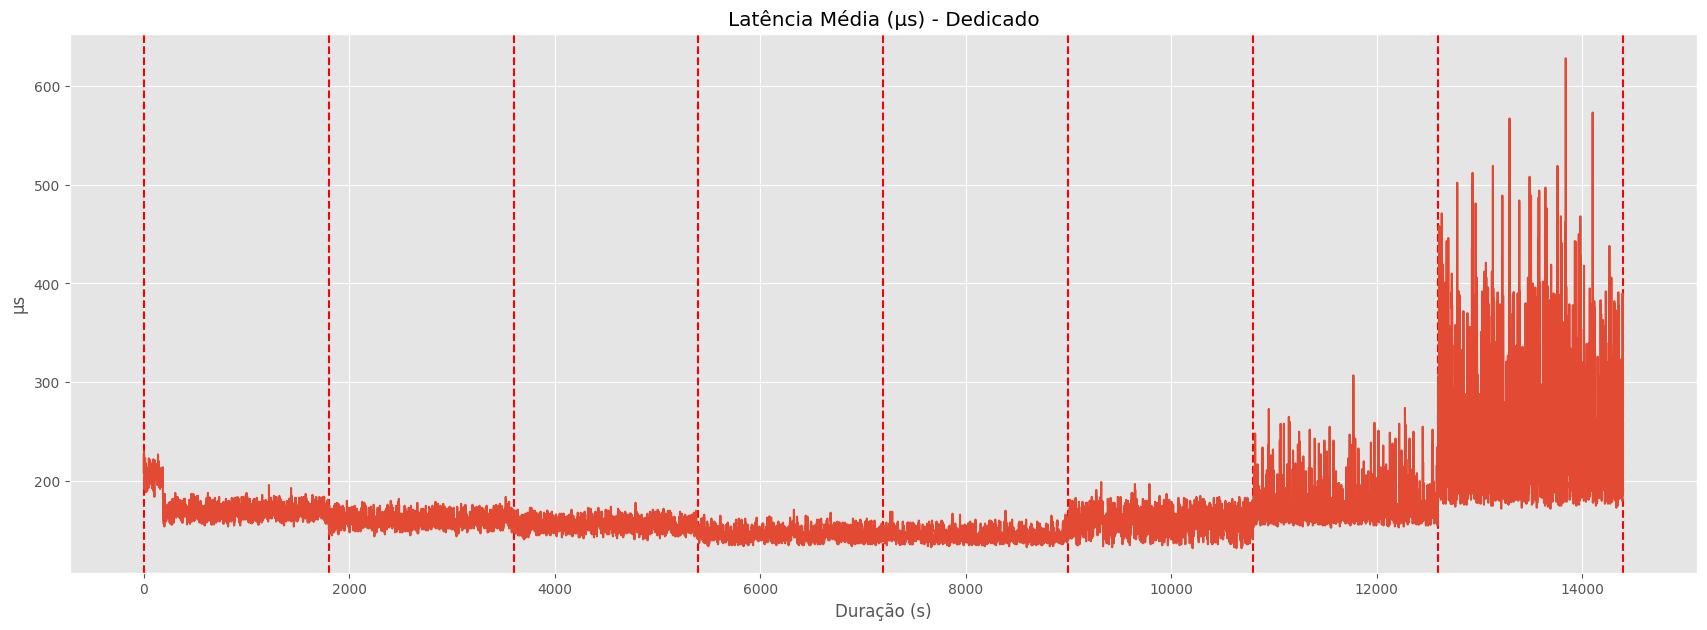

In [16]:
plt.figure(figsize=(21, 7))

assintotas = [0, 1800, 3600, 5400, 7200, 9000, 10800, 12600, 14400]
for x in assintotas:
    plt.axvline(x=x, color='red', linestyle='--', label=f'Assíntota em x = {x}')

plt.plot(dedicado)
plt.title('Latência Média (µs) - Dedicado')
plt.xlabel('Duração (s)')
plt.ylabel("µs")
# plt.grid(True)
plt.show()

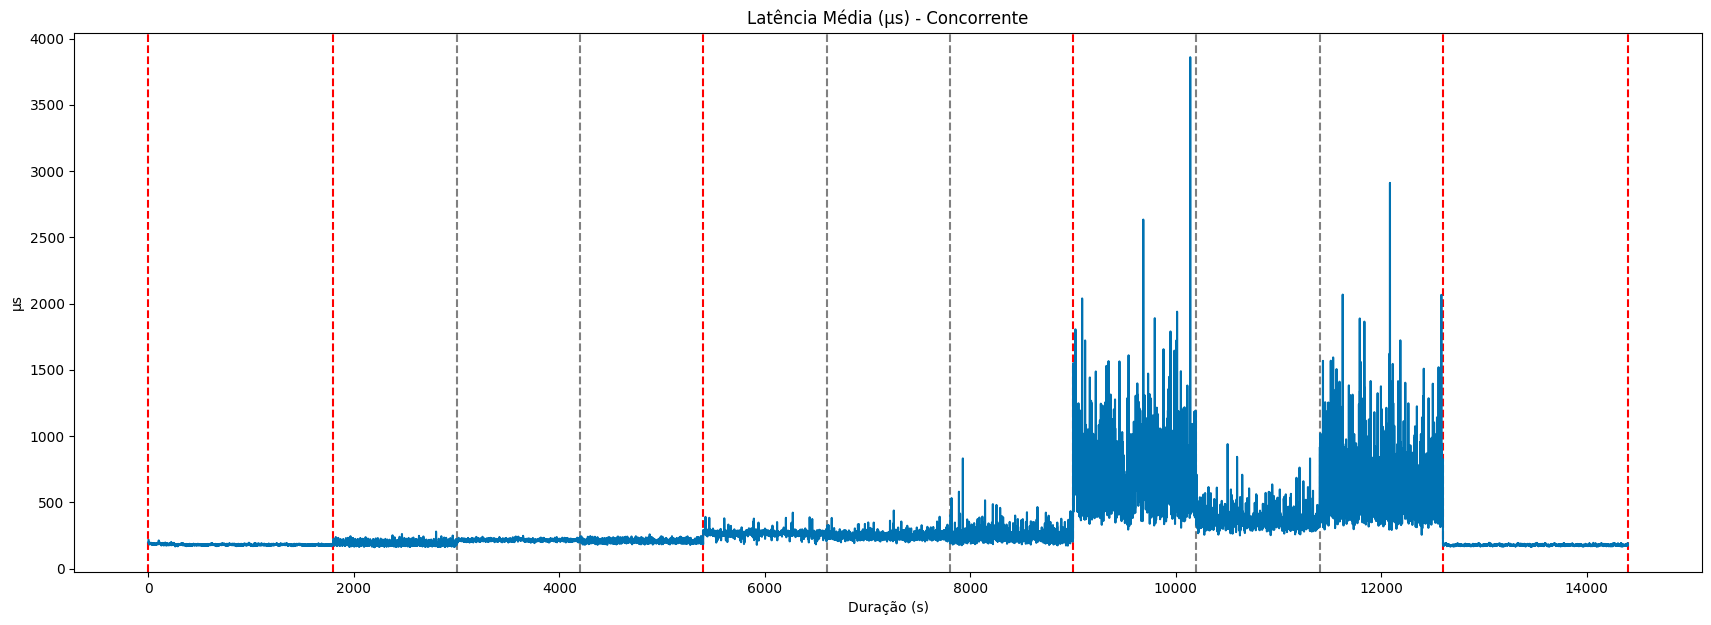

In [117]:
plt.figure(figsize=(21, 7))

assintotas = [0, 1800, 5400, 9000, 12600, 14400]
for x in assintotas:
    plt.axvline(x=x, color='red', linestyle='--', label=f'Assíntota em x = {x}')

sub_assintotas = [3000, 4200, 6600, 7800, 10200, 11400]
for x in sub_assintotas:
    plt.axvline(x=x, color='gray', linestyle='--', label=f'Assíntota em x = {x}')


plt.plot(latencia)
plt.title('Latência Média (µs) - Concorrente')
plt.xlabel('Duração (s)')
plt.ylabel("µs")
# plt.grid(True)
plt.show()

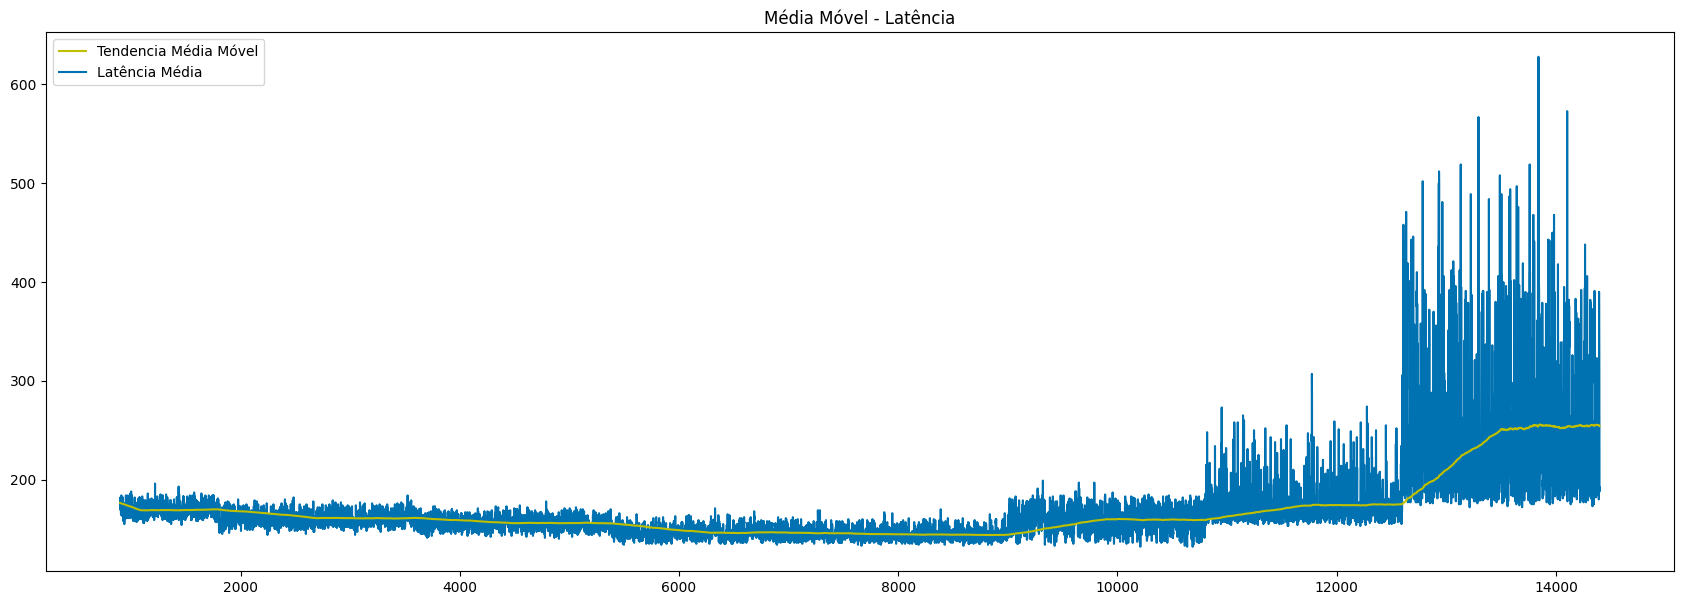

In [136]:
plotMovingAverage(dedicado, 900, 14400)

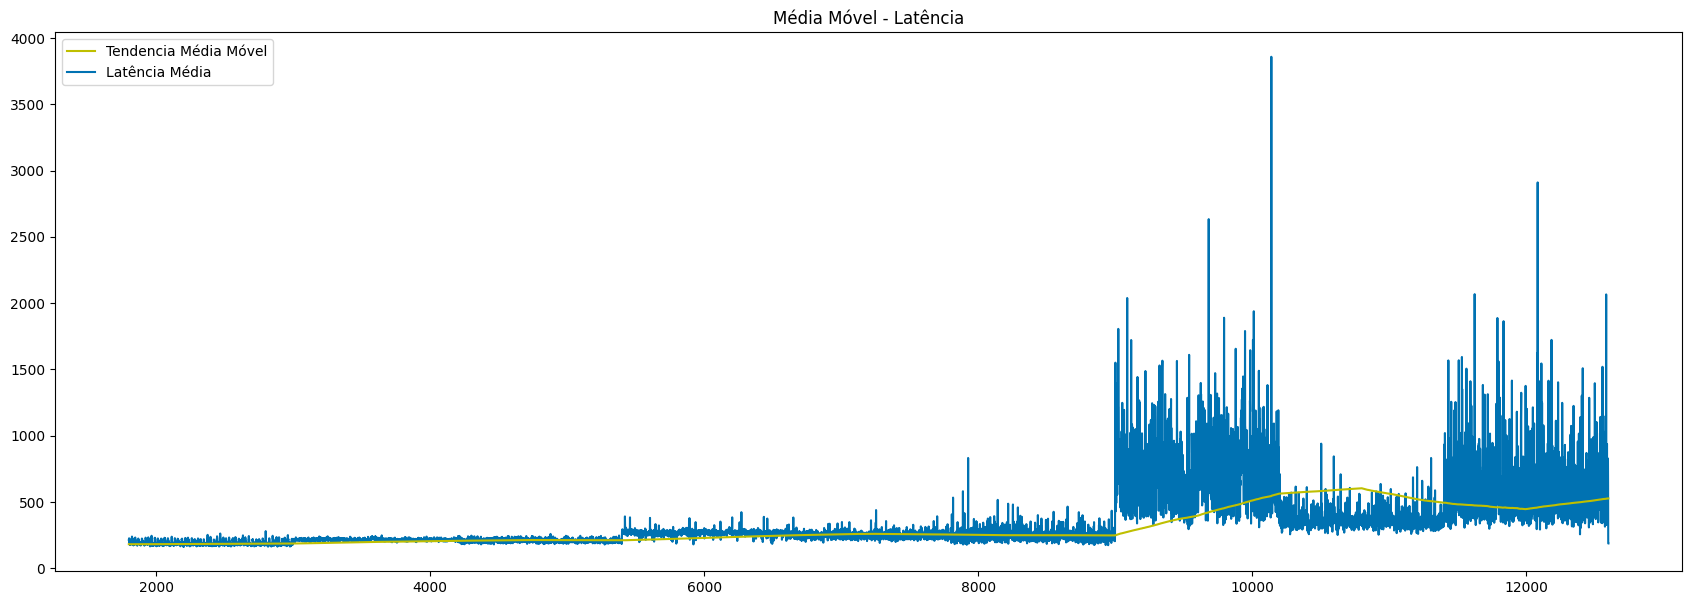

In [137]:
plotMovingAverage(latencia, 1800, 12600)

In [138]:
vazao = df[['sent', 'received']]

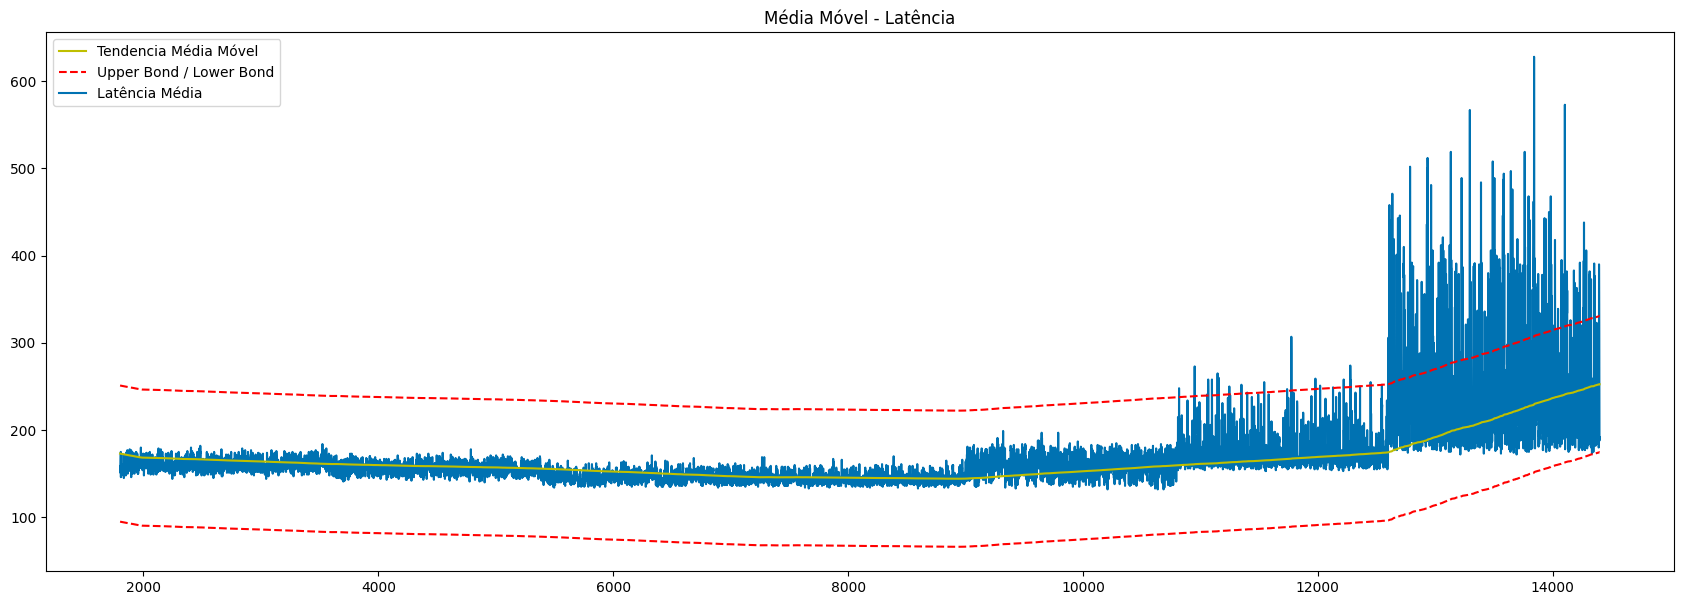

In [143]:
plotMovingAverage(dedicado, 1800, 14400, plot_intervals=True)

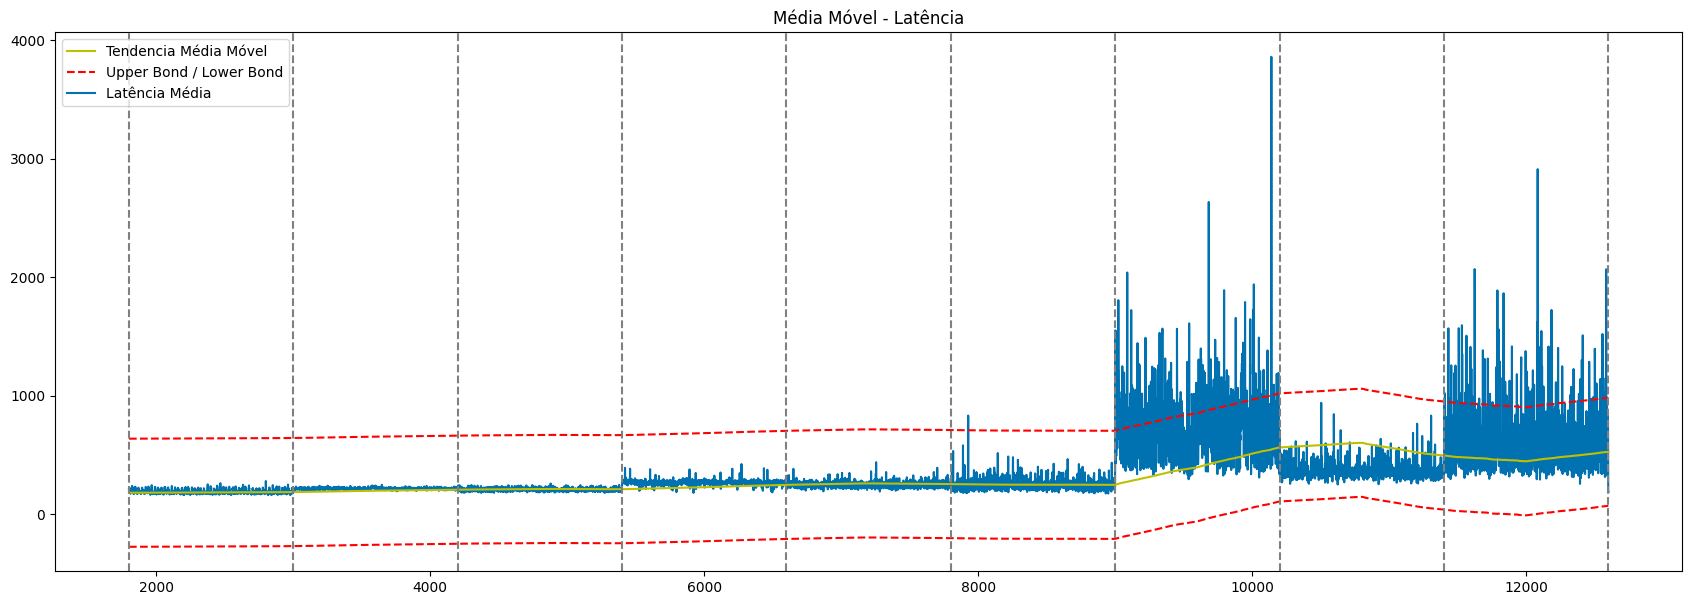

In [140]:
plotMovingAverage(latencia,1800, 12600, plot_intervals=True, assintotas= True, sub_assintotas= True)

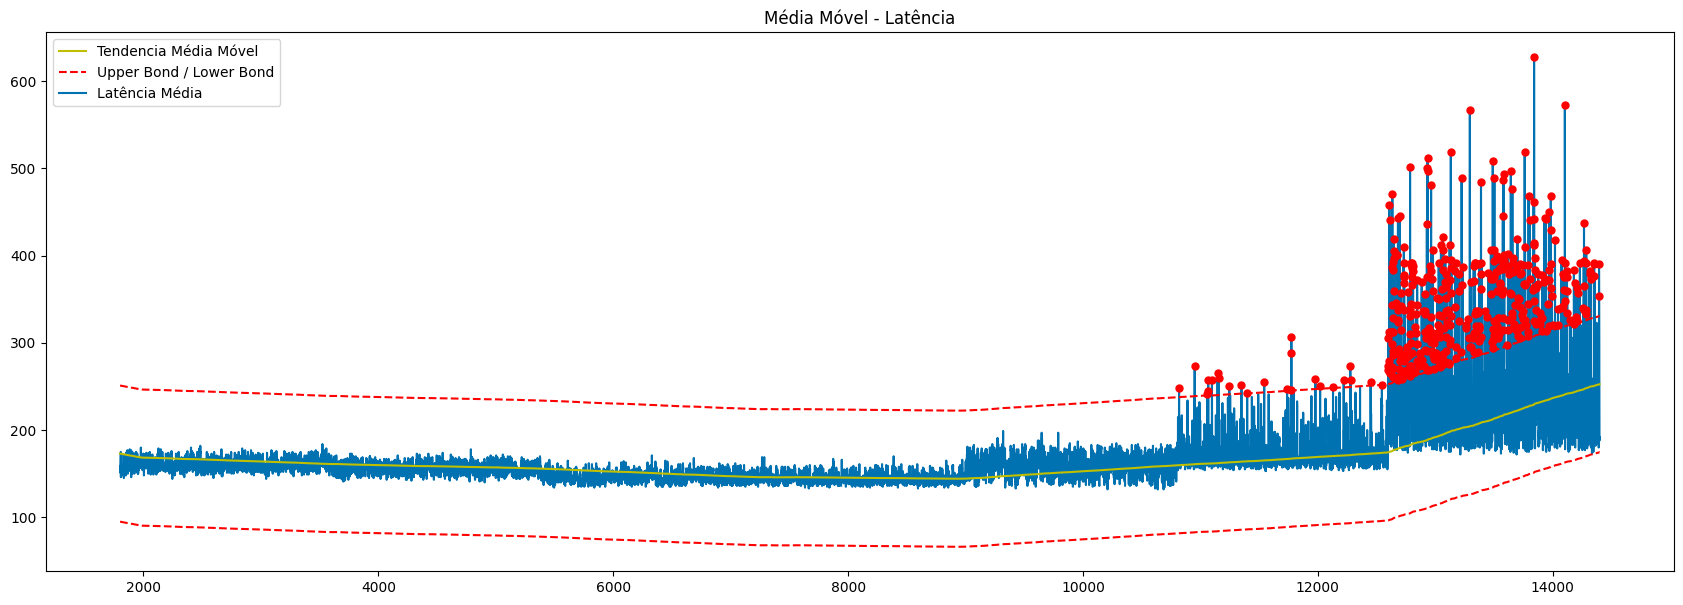

In [125]:
plotMovingAverage(dedicado, 1800, 14400, plot_intervals=True, plot_anomalies=True)

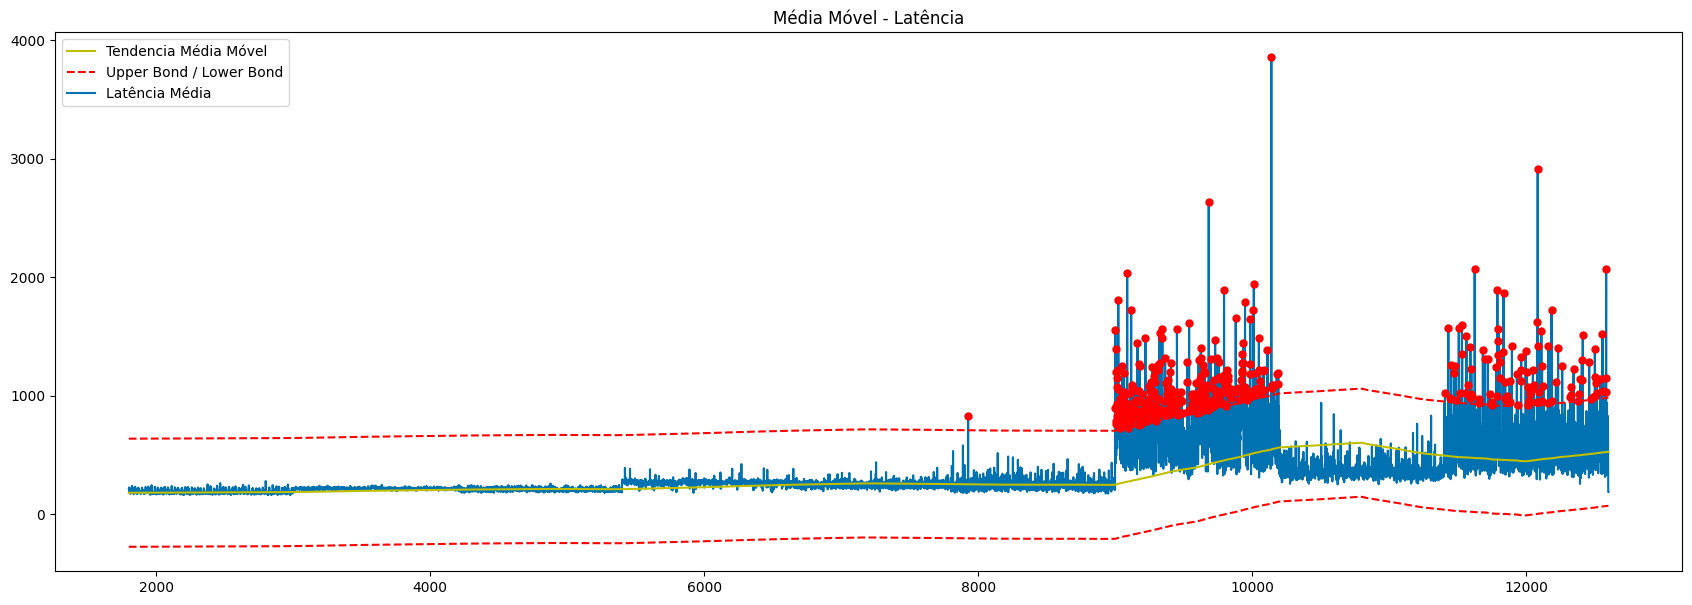

In [126]:
plotMovingAverage(latencia, 1800, 12600, plot_intervals=True, plot_anomalies=True)